In [1]:
!pip install blackjax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.1/300.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 24.4 MB/s eta 0:00:00


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as t
from datetime import date
import jax
import jax.numpy as jnp
import blackjax

In [2]:
class GossetBravyiSpinChain:
  def __init__(self, number_spins, theta, p, periodic_boundary_conditions=False, beta=1.):
    self.number_spins = number_spins
    self.theta = theta
    self.p = p
    self.periodic_boundary_conditions = periodic_boundary_conditions
    self.beta = beta
    self.rotation = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    local_hamiltonian_projector = np.kron(np.eye(2), self.rotation) @ ((np.array([[np.sqrt(1 - p), 0, 0, np.sqrt(p)]])).T)
    self.local_hamiltonian = local_hamiltonian_projector @ (local_hamiltonian_projector.T)

  def cost(self, data):
    @jax.jit
    def qubit_states(data):
      cc = jnp.cos(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.cos(jnp.mod(data[1:], 2 * jnp.pi))
      cs = jnp.cos(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.sin(jnp.mod(data[1:], 2 * jnp.pi))
      sc = jnp.sin(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.cos(jnp.mod(data[1:], 2 * jnp.pi))
      ss = jnp.sin(jnp.mod(data[:-1], 2 * jnp.pi)) * jnp.sin(jnp.mod(data[1:], 2 * jnp.pi))
      return jnp.array([cc, cs, sc, ss], dtype=jnp.float32)
    qs = qubit_states(data)
    return_cost = jnp.trace((qs.T) @ (self.local_hamiltonian @ qs))
    return - self.beta * return_cost


In [24]:
# global constants for sampling algorithm
DEFAULT_WARMUP_TIME = 100
DEFAULT_STEP_SIZE = 0.005 * jnp.pi

class NutsWindowAdapt:
  def __init__(self, problem_instance, initial_position, warmup=True, warmup_time=DEFAULT_WARMUP_TIME):
    self.call_cost_function = lambda x : problem_instance.cost(**x)
    self.initial_position = initial_position
    self.warmup = warmup
    self.rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

    if warmup:
      warmup_sampler = blackjax.window_adaptation(blackjax.nuts, self.call_cost_function)
      _, warmup_key, self.sample_key = jax.random.split(self.rng_key, 3)
      (self.state, self.parameters), _ = warmup_sampler.run(warmup_key, self.initial_position, num_steps=warmup_time)

  def inference_loop(self, rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)
    return states

  def run(self, run_time, inverse_mass_matrix, step_size=DEFAULT_STEP_SIZE):
    if self.warmup:
      kernel = blackjax.nuts(self.call_cost_function, **self.parameters).step
      states = self.inference_loop(self.sample_key, kernel, self.state, run_time)
    else:
      nuts_sampler = blackjax.nuts(self.call_cost_function, step_size, inverse_mass_matrix)
      initial_state = nuts_sampler.init(self.initial_position)
      _, sample_key = jax.random.split(self.rng_key)
      states = self.inference_loop(sample_key, nuts_sampler.step, initial_state, run_time)
    return states

In [25]:
# constants for soft spheres
number_spins = 100
theta = 2. * np.pi / 5.
run_time = 1000

np.random.seed(0)
initial_data = 2 * np.pi * np.random.rand(number_spins)
initial_position = {"data": initial_data}
default_inverse_mass_matrix = np.ones(len(initial_position.keys()))

In [26]:
# correlation function data
magnetization_list = list()
plist = np.linspace(0, 0.5, 20)
for p in plist:
  start_time = t.time()
  gbsc = GossetBravyiSpinChain(number_spins=number_spins, theta=theta, p=p, beta=128)
  nwa = NutsWindowAdapt(gbsc, initial_position, warmup=False)
  history = nwa.run(run_time=run_time, inverse_mass_matrix=default_inverse_mass_matrix)
  history.position["data"] = np.mod(history.position["data"], 1)
  history = history.position['data']
  magnetization_list_item = np.sum(np.cos(history.copy()) - np.sin(history.copy()), axis=1) / number_spins
  magnetization_list.append(magnetization_list_item)
  print(f"p: {np.round(p, 4)}, time elapsed: {np.round(t.time() - start_time, 4)}s")

p: 0.0, time elapsed: 3.9333s
p: 0.0263, time elapsed: 3.993s
p: 0.0526, time elapsed: 7.1563s
p: 0.0789, time elapsed: 6.4731s
p: 0.1053, time elapsed: 7.649s
p: 0.1316, time elapsed: 7.2883s
p: 0.1579, time elapsed: 10.9156s
p: 0.1842, time elapsed: 14.2138s
p: 0.2105, time elapsed: 15.901s
p: 0.2368, time elapsed: 18.4621s
p: 0.2632, time elapsed: 20.3662s
p: 0.2895, time elapsed: 18.7474s
p: 0.3158, time elapsed: 19.4614s
p: 0.3421, time elapsed: 20.6029s
p: 0.3684, time elapsed: 19.4303s
p: 0.3947, time elapsed: 21.1754s
p: 0.4211, time elapsed: 19.169s
p: 0.4474, time elapsed: 20.487s
p: 0.4737, time elapsed: 20.6142s
p: 0.5, time elapsed: 21.2501s


In [27]:
magnetization_list = np.array(magnetization_list)
print(np.max(np.reshape(magnetization_list, [-1])), np.min(np.reshape(magnetization_list, [-1])))

0.59532243 0.13898388


Text(0, 0.5, 'Std. dev. of magnetization')

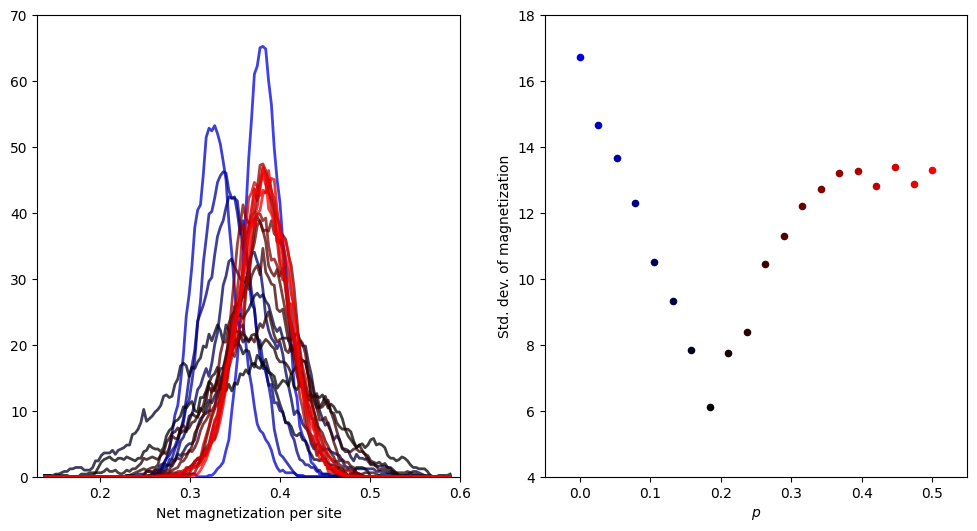

In [75]:
# plotting constants
color='black'
alpha=0.75
linewidth=2
bins = np.linspace(0.13, 0.60, 150)

# plotting data
xaxis = (bins[1:] + bins[:-1])/2
window = 5
average_xaxis = [np.mean(xaxis[i : i + window]) for i in range(len(xaxis) - window)]
size=20

# plot
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
for i in range(len(magnetization_list)):
  histogram_data, bins = np.histogram(magnetization_list[i], bins=bins)
  average_histogram_data = [np.mean(histogram_data[i : i + window]) for i in range(len(histogram_data) - window)]
  if plist[i] < 0.2:
    color = [0, 0, 1 - (i + 1) / len(plist[plist < 0.2])]
    # ax[0].plot(xaxis, histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[0].plot(average_xaxis, average_histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[1].scatter([plist[i]], [np.std(histogram_data)], size, color=color)
  else:
    color = [(i + 1 - len(plist[plist < 0.2])) / len(plist[plist >= 0.2]), 0, 0]
    # ax[0].plot(xaxis, histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[0].plot(average_xaxis, average_histogram_data, alpha=alpha, color=color, linewidth=linewidth)
    ax[1].scatter([plist[i]], [np.std(histogram_data)], size, color=color)

# plot formatting
ax[0].set_xlim([0.13, 0.60])
ax[0].set_xlabel("Net magnetization per site")
ax[0].set_ylim([0, 70])

ax[1].set_xlim([-0.05, 0.55])
ax[1].set_xlabel(r"$p$")
ax[1].set_ylim([4, 18])
ax[1].set_ylabel("Std. dev. of magnetization")